This notebook is the first step into using RC models and measured data to learn the thermal properties of building envelopes. It is a very basic example, with a very simple "building" and a very simple model, which purpose is to introduce the workflow of model calibration. Essential steps, such as data preprocessing, model selection, inference diagnostics, are not presented here but will be in the next notebooks of this series.

The main steps are:
* Monitoring a building (here a simple test box) for the variables that will let us learn its performance
* Selecting a simple model structure that may reproduce these observations
* Fitting the model output on the data using a learning algorithm

Once the model is calibrated, its parameters should then represent the physical properties of the real building. (Of course there are many conditions to meet before we can assume that this is the case, but they are not presented in this introductory notebook).

## The test box and its data

<img src='figures/ssm01_test_box.png' width=600 />

A small box is heated by a 15W lamp, and the indoor temperature is monitored by sensors (EmonTH and Data logger), along with the ambient temperature. By analysing these measurements, we wish to estimate the thermal properties of the box: resistance and capacity. One of the walls of the box is interchangeable: it can be replaced by concrete, wood, insulation, brick... 5 tests have been run with different wall compositions:
* concrete
* brick
* wood
* insulated concrete
* insulated wood

All 5 tests are available in separate tabs in the excel file: `data/test_box.xlsx`

During each test, the lamp is turned on and off a few times, and kept on overnight. The figure below shows the indoor temperature and heating power recorded during one of the tests.

In [1]:
# Some imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Loading data from file
df = pd.read_excel('data/test_box.xlsx', sheet_name='Test 1')

# Showing the dates to pandas and setting them as index
df.set_index(pd.to_datetime(df['DD/MM/AAAA hh:mm']), inplace=True)
df.drop('DD/MM/AAAA hh:mm', axis=1, inplace=True)

# There are some missing values. Let's quickly replace them
df.interpolate(inplace=True)

# Creating a new column with the time step between measurements
df['dt'] = np.concatenate(([0],(df.index[1:] - df.index[:-1]).total_seconds().values))

df.head()

,Ti [°C],HRi [%],Ta [°C],HRe [%],P [W],dt
DD/MM/AAAA hh:mm,,,,,,
2018-06-13 09:00:00,29.2,42.4,23.9,61.3,14.25,0.0
2018-06-13 09:01:00,29.6,41.7,23.9,61.1,14.25,60.0
2018-06-13 09:02:00,30.0,41.1,23.9,61.3,14.25,60.0
2018-06-13 09:03:00,30.3,40.5,23.9,61.3,14.25,60.0
2018-06-13 09:04:00,30.7,40.0,23.9,61.3,14.25,60.0


Now that the dataframe containing one of the tests has been loaded, we can have a look.

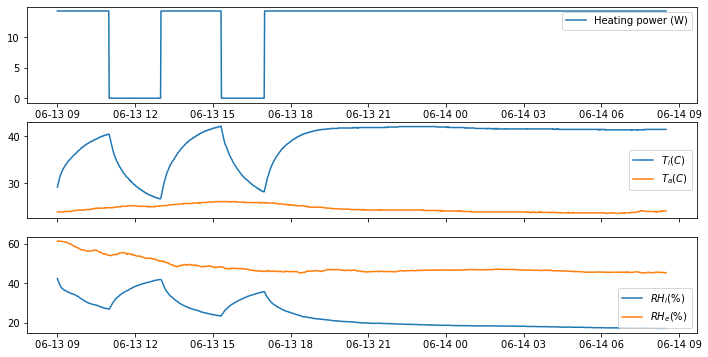

In [3]:
plt.figure(figsize=(12,6))

ax1 = plt.subplot(311)
plt.plot(df['P [W]'], label='Heating power (W)')
plt.legend()
#plt.setp(ax1.get_xticklabels(), fontsize=6)

# share x only
ax2 = plt.subplot(312, sharex=ax1)
plt.plot(df['Ti [°C]'], label='$T_i (C)$')
plt.plot(df['Ta [°C]'], label='$T_a (C)$')
plt.setp(ax2.get_xticklabels(), visible=False)
plt.legend()

# share x and y
ax3 = plt.subplot(313, sharex=ax1)
plt.plot(df['HRi [%]'], label='$RH_i (\%)$')
plt.plot(df['HRe [%]'], label='$RH_e (\%)$')
plt.legend()

plt.show()

We can see that the temperature inside the box $T_i$ is clearly influenced by the heating power being turned on and off. In comparison, the ambient temperature $T_a$ does not vary much. Relative humidities $RH$ show similar trends, because of their dependency on the temperature, but we are not going to use this information here.

## The most simple RC model

We are going to fit a simple RC model on each of the 5 tests, to estimate 5 different values of the thermal resistance $R$ and capacity $C$. The most simple thermal model with which we can represent the box has one resistance and one capacitance.

<img src='figures/ssm01_1r1c.png' width=200 />

$$ C \frac{\partial T_i}{\partial t} = \frac{1}{R} (T_a-T_i) + P$$

The model will let us calculate the value of $T_i$ as a function of the inputs $(T_a, P)$ and the parameters $(R,C)$. The equation is discretised on a time scale $t \in \{1...T\}$ with the same time step size $\Delta t$ as the data:

$$ \left(\frac{C}{\Delta t}+\frac{1}{R}\right) T_i^{t+1} = \frac{C}{\Delta t}T_i^t + \frac{1}{R} T_a^{t+1} + P^{t+1}$$

The model is defined in the following code:

In [4]:
# Input and output arrays taken from the dataframe
df_inputs = df[['Ta [°C]', 'P [W]', 'dt']].values
df_output = df['Ti [°C]'].values

# Function that will calculate the indoor temperature for a given value of R and C
def ti(inputs, R, C):
    
    ta = inputs[:,0]
    p  = inputs[:,1]
    dt = inputs[:,2]
    
    y = np.zeros(len(df_inputs))
    # Initial temperature
    y[0] = df_output[0]
    for t in range(1,len(y)):
        y[t] = 1/(C/dt[t]+1/R) * (C/dt[t]*y[t-1] + 1/R*ta[t] + p[t])
    return y

## Training

Calibrating a model means finding the settings or set of parameters with which its output best matches a series of observations, called a training dataset. This data usually originates from measurements (in either experimental test cells or real buildings), but may also have been produced by a complex reference model that we wish to approximate by a simplified one.

<img src='figures/ssm01_training.png' width=600 />

We can find the optimal parameters $\theta=(R,C)$ by minimizing the sum of squared residuals between the measured indoor temperature and the output of the function we just defined. This is equivalent to what the `curve_fit` method of Scipy does here.

The method requires initial parameter values, which we can find manually beforehand.

In [5]:
import scipy.optimize as so

# The curve_fit function will find the optimal value for the parameters R and C
p_opt, p_cov = so.curve_fit(f=ti,
                            xdata=df_inputs,
                            ydata=df_output,
                            p0=(1., 2000))
# Optimal value for R and C
R_opt = p_opt[0]
C_opt = p_opt[1]
print('R: %.2f K/W' % R_opt)
print('C: %.2f J/K' % C_opt)

R: 1.23 K/W
C: 2278.22 J/K


Finally, we can compare the profile of measured indoor temperature with the output of the model with the identified optimal parameters.

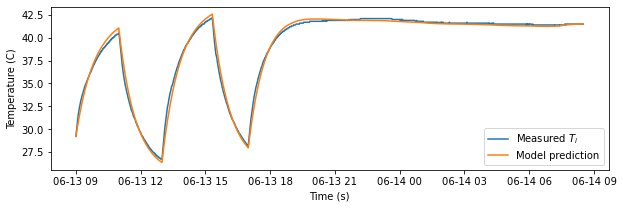

In [6]:
# Plot the results to see if the calculated temperature fits well with measurements
plt.figure(figsize=(10,3))
plt.plot(df.index, df_output, label='Measured $T_i$')
plt.plot(df.index, ti(df_inputs, R_opt, C_opt), label='Model prediction')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show()

There seems to be a reasonable agreement between the data and the model output. A closer look at the prediction residuals would however probably reveal that the model structure is insufficient to accurately represent even this small test box, and that the estimated parameters should thus be used with caution.